## Discover topics from Enron Emails: A demo of how NTM works 
1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
   1. [Create Bag-of-Words and Vocabulary](#Create-Bag-of-Words-and-Vocabulary)
   2. [TF-IDF Term Frequency Inverse Document Frequency](#TF-IDF-Term-Frequency-Inverse-Document-Frequency)
3. [Create Training Validation and Test Datasets](#Create-Training-Validation-and-Test-Datasets)
   1. [Store Data on S3](#Store-Data-on-S3)
   2. [Model Training](#Model-Training)
   3. [Set Hyperparameters](#Set-Hyperparameters)
4. [Model Hosting and Inference](#Model-Hosting-and-Inference)
  1. [Inference with CSV](#Inference-with-CSV)
  2. [Creating Word Cloud from Trained Model](#Creating-Word-Cloud-from-Trained-Model)

## Introduction 

In this notebook, we will look at discovering topics from enron emails. Neural Topic Model (NTM) from Amazon SageMaker uses neural networks to learn word embeddings or topics. The word embeddings are derived by minimizing loss when building stochastic representation of input documents/emails.

First, we build bag of words representation of each email, with each column representing a word and each row representing an email. The values in the matrix are number of times each word is repeated in a given email. We then scale the counts by multiplying them with TF-IDF factor (Term Frequency-Inverse Document Frequency). This factor ensures that words that are specific to a given email and are not repeated frequently across all emails are given higher weight, relative to the words that commonly occur across all emails (for ex: the, so, as, because etc). 

The prepared bag of words representation of emails is then fed into a neural network whose architecture is defined by the hyperparameters listed below. The network optimizes across several epochs by minimizing loss in building stochastic representation of emails (topic embeddings) and in reconstructing original emails from topic embeddings.

The dataset for this notebook is downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bag+of+words). It primarily contains list of words (vocabulary) used across all emails and a lookup table detailing number of occurrences of a word in a given email (EmailID WordID Count)

In [56]:
# **Acknowledgements, Copyright Information, and Availability**
#Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science
    
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import os
from sagemaker import get_execution_role
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.session import s3_input
from sagemaker.model import Model
from sagemaker.predictor import csv_serializer, json_deserializer
import warnings
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Preprocessing 

First, let's run user defined functions used to conduct common operations

In [57]:
run bowemails.py

### Create Bag-of-Words and Vocabulary
We will only take 10% of emails to have a manageable dataset

In [25]:
ip_fn = 'data/docword.enron.txt.gz'
percent_emails = .10 # get only a x% of emails to avoid memory errors
vocab_ip_fn = 'data/vocab.enron.txt'
vocab_op_fn = 'data/vocab.txt'

#Get bag-of-words from input of enron emails
# We will filter emails to reduce data size
# Create vocabulary based on the subset of emails that will be sent to training
pvt_emails = prepare_bow_vocab(ip_fn, percent_emails, vocab_ip_fn, vocab_op_fn)

In [4]:
pvt_emails.head()

word_ID,1,3,4,8,9,15,16,19,20,21,...,28090,28091,28092,28093,28095,28096,28097,28098,28100,28101
email_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
pvt_emails.shape

(3986, 17524)

### TF-IDF Term Frequency Inverse Document Frequency
We assume that the words that help surface topics are those that are not repeated across all emails but are common within an email.

In [27]:
tfidf_emails = TF_IDF(pvt_emails)

In [29]:
# convert pivoted dataframe to compressed sparse row matrix
# compressed sparse row matrix contains row pointer, column index and values
sparse_emails = csr_matrix(pvt_emails, dtype=np.float32)
print(sparse_emails[:16].toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
type(sparse_emails)

scipy.sparse.csr.csr_matrix

## Create Training Validation and Test Datasets

In [30]:
vol_train = int(0.8 * sparse_emails.shape[0])

# split train and test
train_data = sparse_emails[:vol_train, :] 
test_data = sparse_emails[vol_train:, :] 

# further split test set into validation set and test set
vol_test = test_data.shape[0]
val_data = test_data[:vol_test//2, :]
test_data = test_data[vol_test//2:, :]

In [31]:
print(train_data.shape, test_data.shape, val_data.shape)

(3188, 17524) (399, 17524) (399, 17524)


### Store Data on S3

The NTM algorithm, and other built-in SageMaker algorithms, accepts data in CSV or RecordIO Protobuf format. SageMaker algorithms work the best when input data is provided in RecordIO wrapped Protobuf format, an efficient format to encode/serialize structured data

In [6]:
role = get_execution_role()
# provide your bucket name here
#bucket = '<bucket-name>'
bucket = 'ai-in-aws'
prefix = 'enronemails'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')
aux_prefix = os.path.join(prefix, 'aux')

s3loc_train_data = os.path.join('s3://', bucket, train_prefix)
s3loc_val_data = os.path.join('s3://', bucket, val_prefix)
s3loc_aux_data = os.path.join('s3://', bucket, aux_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)

Partition the training data for parallel processing

In [29]:
# Convert compressed sparse row matrix to recordio-wrapped-protobuf format
# RecordIO is used to efficiently load large datasets (data can be read continuously and stored in a compressed format) 

convert_to_pbr(train_data, bucket=bucket, prefix=train_prefix, fname_template='emails_train_part{}.pbr', num_parts=3)
convert_to_pbr(val_data, bucket=bucket, prefix=val_prefix, fname_template='emails_val_part{}.pbr', num_parts=1)

### Model Training

To train NTM in SageMaker, we obtain registry path of training docker image of NTM. Additionally, we create Estimator object from SageMaker Python SDK to provide infrastructure specifications. Then, we set hyperparameters and call fit() method of the estimator created to start training.

In [4]:
container = get_image_uri(boto3.Session().region_name, 'ntm')

In [31]:
sess = sagemaker.Session()
ntm_estmtr = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=2,
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_path,
                                   sagemaker_session=sess)

##### Set Hyperparameters

__feature_dim__ - Represents the size of feature vector. It is set to vocabulary size <br>
__num_topics__ - Represents number of topics to extract. We can choose a number here and adjust it based on model performance on test set <br>
__mini_batch_size__ - Represents number of training examples to process before updating weights <br>
__epochs__ - Represents number of backward and forward passes <br>
__num_patience_epochs__ Represents maximum number of bad epochs (epochs where loss does not improve) executed before stopping <br>
__optimizer__ - We use Adadelta optimization algorithm. Adpative Delta gradient is an enhanced version of Adagrad (Adaptive Gradient), where learning rate decreases based on rolling window of gradient updates vs all past gradient updates<br>
__tolerance__ - Represents threshold for change in loss function - the trainining stops early if the change in loss within the last designated number of patience epochs falls below this threshold 

In [32]:
num_topics = 3
vocab_size = 17524 # from shape from pivoted emails dataframe
ntm_estmtr.set_hyperparameters(num_topics=num_topics, 
                        feature_dim=vocab_size, 
                        mini_batch_size=30, 
                        epochs=150, 
                        num_patience_epochs=5, 
                        tolerance=.001)

In [ ]:
# Upload vocabulary file to auxiliary folder on S3 bucket -- this is used to identify words associated with latent topics
aux_path = s3_aux_data + "/"

!aws s3 cp $vocab_op_fn $aux_path

In [34]:
s3_train = s3_input(s3loc_train_data, distribution='ShardedByS3Key', content_type='application/x-recordio-protobuf')

s3_val = s3_input(s3loc_val_data, distribution='FullyReplicated', content_type='application/x-recordio-protobuf')

s3_aux = s3_input(s3loc_aux_data, distribution='FullyReplicated', content_type='text/plain')

In [35]:
ntm_estmtr.fit({'train': s3_train, 'validation': s3_val, 'auxiliary': s3_aux})

2019-09-02 00:11:12 Starting - Starting the training job...
2019-09-02 00:11:16 Starting - Launching requested ML instances......
2019-09-02 00:12:17 Starting - Preparing the instances for training......
2019-09-02 00:13:20 Downloading - Downloading input data...
2019-09-02 00:13:56 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[09/02/2019 00:14:11 INFO 139681252058944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_dat

In [18]:
print('Training job name: {}'.format(ntm_estmtr.latest_training_job.job_name))

Training job name: ntm-2019-04-09-17-24-19-713


## Model Hosting and Inference

In [21]:
#You can either deploy the trained model using sagemaker estimator object or create a sagemaker and then invoke deploy() method

ntm_predctr = ntm_estmtr.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# OR 

# current_job_name = 'ntm-2019-09-02-00-11-12-089'
# model_path = os.path.join('s3://', bucket, output_prefix, current_job_name, 'output/model.tar.gz')
# ntm_model = Model(model_data=model_path, image=container, role=role, sagemaker_session=sess)
# ntm_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
# ntm_predctr = sagemaker.predictor.RealTimePredictor(
#     ntm_model.endpoint_name, 
#     sagemaker_session=sess
#      )

In [20]:
print('Endpoint name: {}'.format(ntm_model.endpoint_name))

Endpoint name: ntm-2019-09-02-11-59-50-170


### Inference with CSV

In [22]:
ntm_predctr.content_type = 'text/csv'
ntm_predctr.serializer = csv_serializer
ntm_predctr.deserializer = json_deserializer

In [32]:
#Convert test vectors from compressed sparse matrix to dense matrix
test_data = np.array(test_data.todense())

In [ ]:
results = ntm_predctr.predict(test_data[1:6])
print(results)

In [34]:
topic_wts_res = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(topic_wts_res)

[[0.04416979 0.50438106 0.45144916]
 [0.03966784 0.47783577 0.48249644]
 [0.0343897  0.47826818 0.48734212]
 [0.04246533 0.72791708 0.22961761]
 [0.04536712 0.29173526 0.66289765]]


Text(0.5, 0, 'Topic Number')

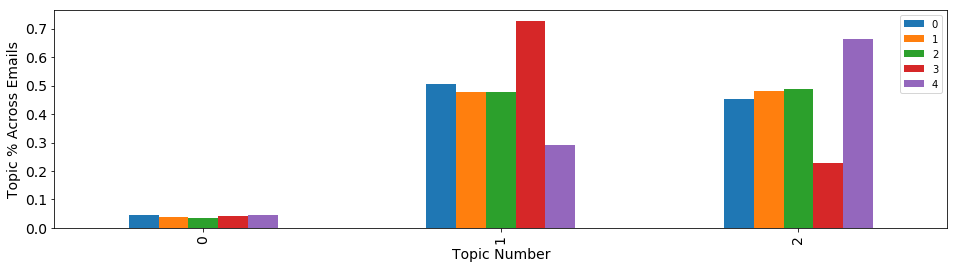

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fnt_sz=14

df_tpcwts=pd.DataFrame(topic_wts_res.T)

df_tpcwts.plot(kind='bar', figsize=(16,4), fontsize=fnt_sz)

plt.ylabel('Topic % Across Emails', fontsize=fnt_sz)
plt.xlabel('Topic Number', fontsize=fnt_sz)

### Creating Word Cloud from Trained Model

In [39]:
!pip install mxnet
!pip install wordcloud
import wordcloud as wc
import mxnet as mx

    100% |████████████████████████████████| 25.4MB 1.7MB/s eta 0:00:01
    100% |████████████████████████████████| 20.4MB 2.9MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 368kB 24.8MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
#Determine the location of the model output
current_job_name = ntm_estmtr.latest_training_job.job_name

model_path = os.path.join(output_prefix, current_job_name, 'output/model.tar.gz')
model_path

'enronemails/output/ntm-2019-04-09-17-24-19-713/output/model.tar.gz'

In [41]:
#Download the model
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [42]:
#unzip the model output
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [43]:
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [46]:
model_dict = mx.ndarray.load('params')
W = model_dict['arg:projection_weight']

In [41]:
# Retrieving word distributions for each of the latent topics 
W


[[-1.6004856 -2.60862   -1.9256244]
 [-1.5195873 -2.801778  -2.5669572]
 [-1.5795462 -2.8432672 -2.3337717]
 ...
 [-1.5052562 -2.8511627 -2.35806  ]
 [-1.5185319 -2.8104594 -2.4379675]
 [-1.5643051 -2.8513684 -2.3724968]]
<NDArray 17524x3 @cpu(0)>

In [47]:
# Create vocabulary list
vocab_list = pd.read_table(vocab_op_fn, header=None)
vocab_list = vocab_list[0].tolist()
len(vocab_list)

17524

In [48]:
#Iterate through the vocabulary list to create dictionary of key values for each of the words in vocabulary
word_to_id = {}

for i, v in enumerate(vocab_list):
    #print("Index and Value", i, v)
    word_to_id[v] = i
    
limit = 24
n_col = 4
counter = 0

In [50]:
word_to_id

{'aaa': 0,
 'aactive': 1,
 'aadvantage': 2,
 'aaron': 3,
 'aarp': 4,
 'aba': 5,
 'abacus': 6,
 'abandon': 7,
 'abandoned': 8,
 'abandoning': 9,
 'abated': 10,
 'abb': 11,
 'abbott': 12,
 'abbreviated': 13,
 'abbreviation': 14,
 'abc': 15,
 'abel': 16,
 'aberration': 17,
 'abide': 18,
 'abilene': 19,
 'abilities': 20,
 'ability': 21,
 'able': 22,
 'abn': 23,
 'aboard': 24,
 'abolish': 25,
 'abolishing': 26,
 'abound': 27,
 'abovemarket': 28,
 'abraham': 29,
 'abreast': 30,
 'abroad': 31,
 'abrogate': 32,
 'abrupt': 33,
 'abruptly': 34,
 'absence': 35,
 'absences': 36,
 'absent': 37,
 'absentee': 38,
 'absolute': 39,
 'absolutely': 40,
 'absorb': 41,
 'absorbed': 42,
 'absorbing': 43,
 'abstract': 44,
 'abt': 45,
 'abundance': 46,
 'abundant': 47,
 'abuse': 48,
 'abuses': 49,
 'academia': 50,
 'academic': 51,
 'academy': 52,
 'acc': 53,
 'accelerate': 54,
 'accelerated': 55,
 'accelerates': 56,
 'accelerating': 57,
 'acceleration': 58,
 'accent': 59,
 'accenture': 60,
 'accept': 61,
 'ac

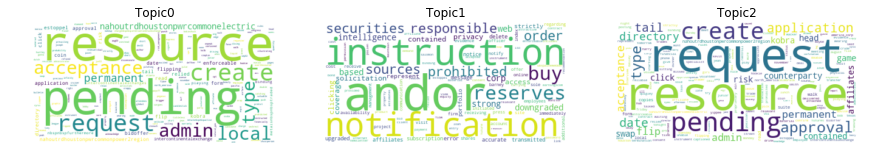

In [51]:
# For each of the topics synthesized, get the word distribution
plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #Use softmax function to assign probability for each of the word associated with the topic
    # The sum of all the probabilities of words associated with each topic should add up to 1
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    #print("Printing pvals: ", len(pvals))
    
    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1